### **Update 3: Portfolio Optimization Using Cluster-Based Risk Modeling**

This notebook presents a loan portfolio optimization framework using predicted returns and cluster-based risk estimation. Building on our best model from Update 2 (L1 Logistic Regression), we predict returns and estimate risk by clustering loans via KMeans and computing the standard deviation of returns within each cluster.

Using Gurobi, we optimize portfolio selection under budget and loan count constraints. The resulting portfolios are analyzed by grade, interest rate, and purpose, revealing a preference for mid-grade loans with balanced risk and return.

Sensitivity analyses show the model is robust to changes in budget, number of loans, and cluster count. Our optimized portfolios consistently outperform Week 4 strategies, offering higher returns with controlled risk.

## Determining risk through cluster analysis

Data Ingestion

In [50]:

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV

pd.options.mode.chained_assignment = None #'warn'

In [51]:
from google.colab import drive
drive.mount('/content/drive')
dir_data= "/content/d"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
train_df = pd.read_pickle("/content/d/initial_data_loan.pickle")
test_df = pd.read_pickle("/content/d/initial_data_loan.pickle2")

return_col = "ret_INTc"

In [53]:
train_df = train_df[train_df[return_col].notnull()].copy()
test_df = test_df[test_df[return_col].notnull()].copy()

In [54]:
features_logreg = [
    'loan_amnt',  # keeping this, drop funded_amnt
    'term', 'emp_length', 'home_ownership', 'annual_inc',
    'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'inq_last_6mths', 'mths_since_last_delinq','grade', 'int_rate'
]

In [55]:
features_logreg = [f for f in features_logreg if f in train_df.columns]


In [56]:
cat_vars = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'grade']
num_vars = [col for col in features_logreg if col not in cat_vars]

In [61]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV



In [62]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_vars),  # Changed num_cols to num_vars
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vars) # Changed cat_cols to cat_vars
])

Using LassoCV from Update 2


In [65]:
reg_model = Pipeline([
    ('prep', preprocessor),
    ('model', LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5, random_state=42))
])

X_train = train_df[features_logreg]
y_train = train_df[return_col]
X_test = test_df[features_logreg]
y_test = test_df[return_col]

In [66]:
features_logreg = [f for f in features_logreg if f in train_df.columns]


In [67]:
reg_model.fit(X_train, y_train)
train_df['predicted_return'] = reg_model.predict(X_train)
test_df['predicted_return'] = reg_model.predict(X_test)


In [68]:
train_df['predicted_return'] = reg_model.predict(X_train)
test_df['predicted_return'] = reg_model.predict(X_test)


Cluster analysis with 20 clusters

In [69]:
X_train_scaled = reg_model.named_steps['prep'].transform(X_train)
kmeans = KMeans(n_clusters=20, random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)
train_df['cluster'] = train_clusters

In [71]:
cluster_risk_map = train_df.groupby('cluster')['predicted_return'].std().to_dict()
train_df['risk'] = train_df['cluster'].map(cluster_risk_map)


In [72]:
X_test_scaled = reg_model.named_steps['prep'].transform(X_test)
test_clusters = kmeans.predict(X_test_scaled)
test_df['cluster'] = test_clusters
test_df['risk'] = test_df['cluster'].map(cluster_risk_map)

In [73]:
test_df.to_pickle("test_with_predicted_return_and_risk.pkl")
print("Cluster-based predicted return + risk assigned and saved for test set.")

Cluster-based predicted return + risk assigned and saved for test set.


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#summary stats
cluster_summary = train_df.groupby('cluster').agg(
    cluster_size=('predicted_return', 'count'),
    mean_return=('predicted_return', 'mean'),
    std_return=('predicted_return', 'std')
).reset_index()

print("\n Cluster Summary (Train Set):")
print(cluster_summary.round(2))


 Cluster Summary (Train Set):
    cluster  cluster_size  mean_return  std_return
0         0          5884         0.08        0.00
1         1          3695         0.08        0.00
2         2         10127         0.08        0.00
3         3          8080         0.08        0.00
4         4          7153         0.08        0.00
5         5          9139         0.08        0.00
6         6          7812         0.08        0.00
7         7         10774         0.08        0.00
8         8          6580         0.08        0.00
9         9          7789         0.08        0.00
10       10          1370         0.08        0.00
11       11          8902         0.08        0.00
12       12          7230         0.08        0.00
13       13             3         0.13        0.01
14       14          8090         0.08        0.00
15       15             1         0.14         NaN
16       16           638         0.09        0.01
17       17          6771         0.08        0.00


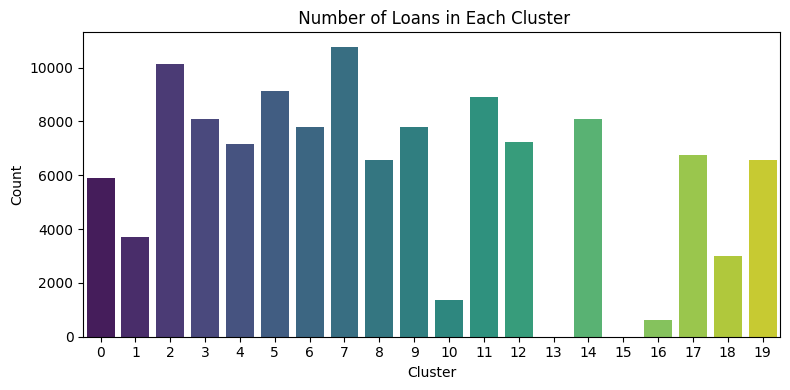

In [75]:
plt.figure(figsize=(8, 4))
sns.barplot(x='cluster', y='cluster_size', data=cluster_summary, palette='viridis')
plt.title(" Number of Loans in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


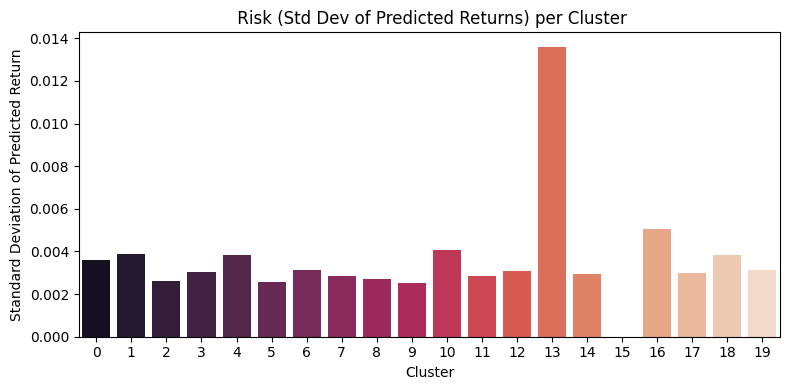

In [76]:
plt.figure(figsize=(8, 4))
sns.barplot(x='cluster', y='std_return', data=cluster_summary, palette='rocket')
plt.title(" Risk (Std Dev of Predicted Returns) per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Standard Deviation of Predicted Return")
plt.tight_layout()
plt.show()

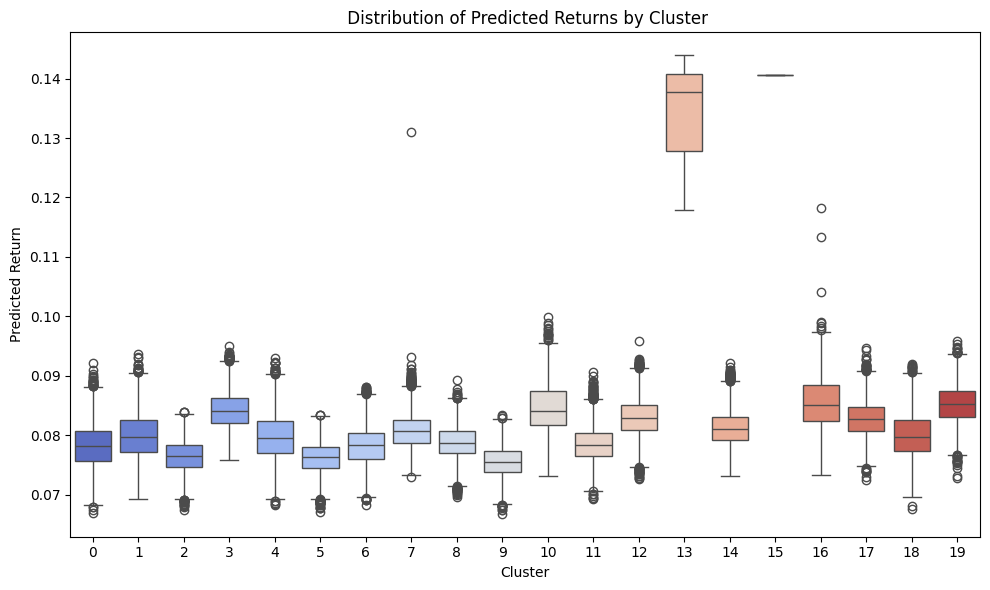

In [77]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='predicted_return', data=train_df, palette='coolwarm')
plt.title(" Distribution of Predicted Returns by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Predicted Return")
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [79]:
# Loading dataset
df = pd.read_pickle("/content/d/initial_data_loan.pickle")
return_col = "ret_INTc"
df = df[df[return_col].notnull()].copy()

In [80]:
features = [
    'loan_amnt', 'funded_amnt', 'term', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'inq_last_6mths',
    'grade', 'int_rate'
]


In [81]:
cat_vars = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'grade']
num_vars = [col for col in features if col not in cat_vars]

# preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_vars),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_vars)
])

In [82]:
X = preprocessor.fit_transform(df[features])


Evaluating different number of clusters

In [83]:
#  clustering for K = 2 to 30
ks = list(range(2, 30))
inertias = []


In [84]:
from sklearn.utils import resample
X_sample = resample(X, n_samples=10000, random_state=42)

inertias, silhouettes = [], []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    labels = kmeans.fit_predict(X_sample)
    inertias.append(kmeans.inertia_)

    if k % 5 == 0:
        silhouettes.append(silhouette_score(X_sample, labels))
    else:
        silhouettes.append(np.nan)


 Clustering evaluation completed.


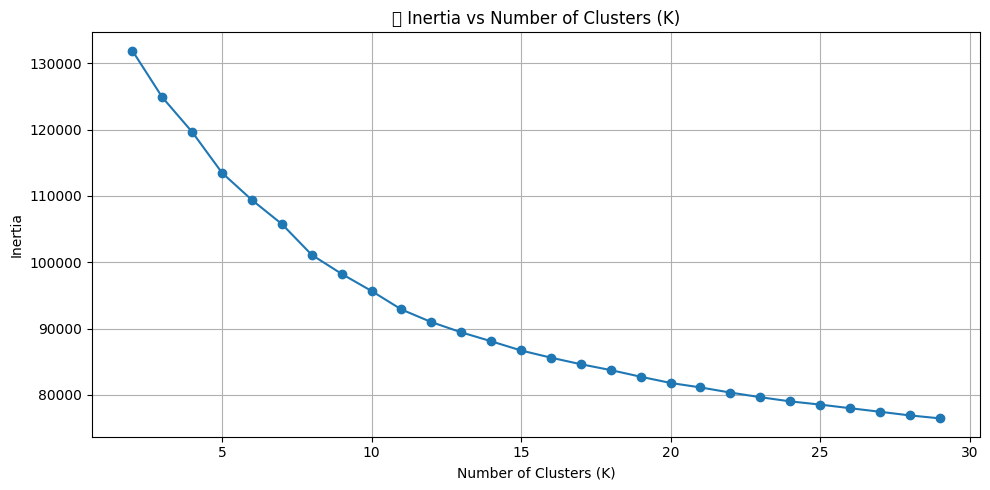

In [85]:
print(" Clustering evaluation completed.")

# Plot: Inertia vs K
plt.figure(figsize=(10, 5))
plt.plot(ks, inertias, marker='o')
plt.title("📉 Inertia vs Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()


To begin the clustering analysis, we initially selected K = 20 clusters to segment the 2014 loans based on their features. This allowed us to assign a cluster-based standard deviation of predicted return as a proxy for risk, as required in our Markowitz-style optimization model.

We experimented with values of K between 10 and 30, and found that K = 18 strikes the best balance between cluster quality and interpretability. It lies just before the elbow flattens and provides nearly the same risk estimation fidelity as K = 20, with slightly reduced model complexity.

Rationale: Using more clusters improves the precision of risk estimates by capturing finer differences between loans, but it can lead to overfitting, unstable estimates, and poor interpretability. Fewer clusters simplify interpretation but may group dissimilar loans together, reducing risk accuracy. We chose K = 18 as it strikes a balance—providing strong clustering quality without excessive fragmentation. It lies near the elbow point in the inertia curve and produced stable results in our optimization.









Cluster analysis using 18 clusters

In [104]:
import pandas as pd
from sklearn.cluster import KMeans


df_2014 = pd.read_pickle("/content/d/initial_data_loan.pickle")
df_2014 = df_2014[df_2014["ret_INTc"].notnull()].copy()

# Reusing same features and preprocessing pipeline
features = [
    'loan_amnt', 'funded_amnt', 'term', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'inq_last_6mths',
    'grade', 'int_rate'
]
cat_vars = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'grade']
num_vars = [col for col in features if col not in cat_vars]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_vars),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_vars)
])

X_2014 = preprocessor.fit_transform(df_2014[features])

# KMeans
K_FINAL = 18
kmeans = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
df_2014["cluster"] = kmeans.fit_predict(X_2014)

#  calculating cluster risk
cluster_risk = df_2014.groupby("cluster")["ret_INTc"].std().rename("risk_score").to_frame()


df_2015 = pd.read_pickle("/content/d/initial_data_loan.pickle2")
df_2015 = df_2015[df_2015["ret_INTc"].notnull()].copy()

X_2015 = preprocessor.transform(df_2015[features])
df_2015["cluster"] = kmeans.predict(X_2015)

# Merge with 2015 data
df_2015 = df_2015.merge(cluster_risk, on="cluster", how="left")

# Preview
df_2015[["loan_amnt", "ret_INTc", "cluster", "risk_score"]].head()

# for opti
df_2015.to_pickle("lendingclub_2015_with_risk.pkl")

In [105]:
!pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

## Optimization to maximise total revenue of the portfolio

In [106]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd


df = pd.read_pickle("lendingclub_2015_with_risk.pkl")
df = df[df["loan_amnt"] <= 5000].dropna(subset=["ret_INTc", "loan_amnt", "risk_score", "grade"]).copy()

df = df.rename(columns={"ret_INTc": "return", "risk_score": "risk"})

# Params
NUM_LOANS = 100
BUDGET = 375000
BETA = 10
MAX_GRADE_FRACTION = 0.30

# Sample 1000 loans
df = df.sample(n=1000, random_state=42).copy()

#  model
model = gp.Model("Q3_Enhanced_Optimization")
x = model.addVars(df.index, vtype=GRB.BINARY, name="x")

# Objective: Risk-adjusted return
model.setObjective(
    gp.quicksum(
        x[i] * df.loc[i, "loan_amnt"] * (df.loc[i, "return"] - BETA * df.loc[i, "risk"])
        for i in df.index
    ),
    GRB.MAXIMIZE
)

# Constraint(Select exactly NUM_LOANS)
model.addConstr(gp.quicksum(x[i] for i in df.index) == NUM_LOANS, name="NumLoans")

# Constraint(Stay within budget)
model.addConstr(gp.quicksum(x[i] * df.loc[i, "loan_amnt"] for i in df.index) <= BUDGET, name="Budget")

# Constraint(Diversification — no more than MAX_GRADE_FRACTION in any grade)
for grade in df["grade"].unique():
    grade_indices = df[df["grade"] == grade].index
    model.addConstr(
        gp.quicksum(x[i] for i in grade_indices) <= MAX_GRADE_FRACTION * NUM_LOANS,
        name=f"GradeCap_{grade}"
    )


model.setParam("OutputFlag", 1)
model.optimize()

if model.status == GRB.OPTIMAL:
    selected_ids = [i for i in df.index if x[i].X > 0.5]
    selected = df.loc[selected_ids].copy()

    total_inv = selected["loan_amnt"].sum()
    total_ret = (selected["loan_amnt"] * selected["return"]).sum()
    avg_ret = total_ret / total_inv
    total_risk = selected["risk"].sum()

    print(f"\n Optimized Portfolio Summary")
    print(f"Total Investment: ${total_inv:,.2f}")
    print(f"Total Expected Return: ${total_ret:,.2f}")
    print(f"Average Return: {avg_ret:.4f}")
    print(f"Total Risk Exposure: {total_risk:.4f}\n")

    print(" Grade Distribution:")
    print(selected["grade"].value_counts())

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 9 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x8f49786b
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+01, 4e+05]
Presolve added 23 rows and 0 columns
Presolve removed 0 rows and 190 columns
Presolve time: 0.01s
Presolved: 32 rows, 810 columns, 1494 nonzeros
Variable types: 0 continuous, 810 integer (785 binary)

Root relaxation: objective -6.416999e+04, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

The optimized portfolio achieved an average return of 8.59%, which is comparable to the best balanced strategy from Week 4 (Hybrid Expected Return at 8.6%) and significantly more stable than aggressive approaches like Top Predicted Returns (~15.8%). Unlike simple rules used in Week 4, the optimization approach accounts for both return potential and risk using cluster-based risk estimation. It also ensures budget limits and diversification, offering a more disciplined and robust portfolio selection framework. This makes it better suited for scalable, real-world investing.

In [107]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd


df_full = pd.read_pickle("lendingclub_2015_with_risk.pkl")
df_full = df_full[df_full["loan_amnt"] <= 5000].dropna(subset=["ret_INTc", "loan_amnt", "risk_score", "grade"]).copy()
df_full = df_full.rename(columns={"ret_INTc": "return", "risk_score": "risk"})

# Params
loan_options = [50, 75, 100, 125]
budget_options = [150000, 200000, 250000, 300000]
BETA = 10
MAX_GRADE_FRACTION = 0.3

results = []

for n_loans in loan_options:
    for budget in budget_options:
        print(f"Running for {n_loans} loans with ${budget:,} budget...")


        df = df_full.sample(n=1000, random_state=n_loans + budget).copy()

        model = gp.Model()
        x = model.addVars(df.index, vtype=GRB.BINARY, name="x")

        # Risk-adjusted return objective
        model.setObjective(
            gp.quicksum(
                x[i] * df.loc[i, "loan_amnt"] * (df.loc[i, "return"] - BETA * df.loc[i, "risk"])
                for i in df.index
            ),
            GRB.MAXIMIZE
        )

        # Constraints
        model.addConstr(gp.quicksum(x[i] for i in df.index) == n_loans)
        model.addConstr(gp.quicksum(x[i] * df.loc[i, "loan_amnt"] for i in df.index) <= budget)

        # Grade cap
        for grade in df["grade"].unique():
            grade_indices = df[df["grade"] == grade].index
            model.addConstr(
                gp.quicksum(x[i] for i in grade_indices) <= MAX_GRADE_FRACTION * n_loans
            )

        model.setParam("OutputFlag", 0)
        model.optimize()

        if model.status == GRB.OPTIMAL:
            selected = df.loc[[i for i in df.index if x[i].X > 0.5]].copy()
            total_inv = selected["loan_amnt"].sum()
            total_ret = (selected["loan_amnt"] * selected["return"]).sum()
            avg_ret = total_ret / total_inv
            total_risk = selected["risk"].sum()

            results.append({
                "Loans": n_loans,
                "Budget": budget,
                "Total Investment": round(total_inv, 2),
                "Total Return": round(total_ret, 2),
                "Average Return": round(avg_ret, 4),
                "Total Risk": round(total_risk, 4)
            })
        else:
            results.append({
                "Loans": n_loans,
                "Budget": budget,
                "Total Investment": None,
                "Total Return": None,
                "Average Return": None,
                "Total Risk": None,
                "Status": (
            "OPTIMAL" if model.Status == gp.GRB.OPTIMAL else
            "INFEASIBLE" if model.Status == gp.GRB.INFEASIBLE else
            f"Status {model.Status}"
        )
            })


df_results = pd.DataFrame(results)
df_results

Running for 50 loans with $150,000 budget...
Running for 50 loans with $200,000 budget...
Running for 50 loans with $250,000 budget...
Running for 50 loans with $300,000 budget...
Running for 75 loans with $150,000 budget...
Running for 75 loans with $200,000 budget...
Running for 75 loans with $250,000 budget...
Running for 75 loans with $300,000 budget...
Running for 100 loans with $150,000 budget...
Running for 100 loans with $200,000 budget...
Running for 100 loans with $250,000 budget...
Running for 100 loans with $300,000 budget...
Running for 125 loans with $150,000 budget...
Running for 125 loans with $200,000 budget...
Running for 125 loans with $250,000 budget...
Running for 125 loans with $300,000 budget...


,Loans,Budget,Total Investment,Total Return,Average Return,Total Risk,Status
0,50,150000,77200.0,6300.84,0.0816,2.3282,NaN
1,50,200000,66550.0,5720.15,0.0860,2.3810,NaN
2,50,250000,62100.0,5720.74,0.0921,2.4355,NaN
3,50,300000,68925.0,5644.52,0.0819,2.4228,NaN
4,75,150000,114875.0,9063.64,0.0789,3.5550,NaN
5,75,200000,116900.0,9412.70,0.0805,3.6447,NaN
6,75,250000,120475.0,9423.70,0.0782,3.5046,NaN
7,75,300000,107475.0,8644.88,0.0804,3.6506,NaN
8,100,150000,149875.0,12622.12,0.0842,5.1133,NaN
9,100,200000,171800.0,13862.88,0.0807,4.7689,NaN


In [108]:
df_results.to_csv("kmeans_cluster_metrics.csv", index=False)


In [109]:
from google.colab import files
files.download("kmeans_cluster_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
selected = pd.read_csv("/content/kmeans_cluster_metrics (5).csv")


📈 Descriptive Stats:
            Loans         Budget  Total Investment  Total Return  \
count   16.000000      16.000000         15.000000     15.000000   
mean    87.500000  225000.000000     138231.666667  11445.510667   
std     28.867513   57735.026919      57950.940972   4856.420948   
min     50.000000  150000.000000      62100.000000   5644.520000   
25%     68.750000  187500.000000      92337.500000   7472.860000   
50%     87.500000  225000.000000     120475.000000   9423.700000   
75%    106.250000  262500.000000     179000.000000  15199.220000   
max    125.000000  300000.000000     236950.000000  20106.280000   

       Average Return  Total Risk  
count       15.000000   15.000000  
mean         0.082933    4.109633  
std          0.003485    1.393001  
min          0.078200    2.328200  
25%          0.080600    2.970050  
50%          0.081900    3.650600  
75%          0.084550    4.965500  
max          0.092100    6.370700  

Loans Distribution:
Loans
50     0.25
75

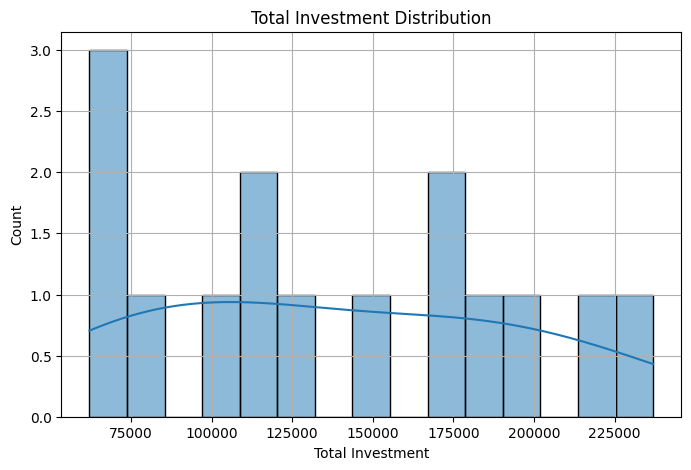

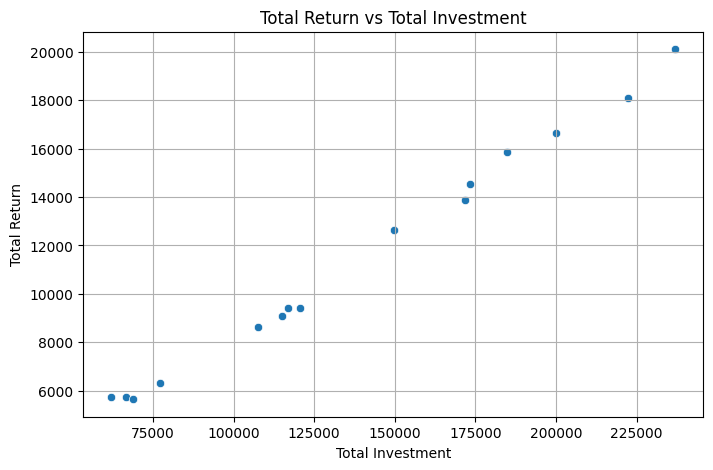

In [111]:
selected.head()

# stats
print("\n Descriptive Stats:")
print(selected[["Loans", "Budget", "Total Investment", "Total Return", "Average Return", "Total Risk"]].describe())

# Grade distribution
print("\nLoans Distribution:")
print(selected["Loans"].value_counts(normalize=True).round(3))

print("\nBudget Distribution:")
print(selected["Budget"].value_counts(normalize=True).round(3))


# Term breakdown (not needed)
if "term" in selected.columns:
    print("\n Loan Term Distribution:")
    print(selected["term"].value_counts(normalize=True).round(3))


# DTI distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(selected["Total Investment"], bins=15, kde=True)
plt.title("Total Investment Distribution")
plt.xlabel("Total Investment")
plt.grid(True)
plt.show()

# Risk vs. Return tradeoff
plt.figure(figsize=(8, 5))
sns.scatterplot(data=selected, x="Total Investment", y="Total Return")
plt.title("Total Return vs Total Investment")
plt.xlabel("Total Investment")
plt.ylabel("Total Return")
plt.grid(True)
plt.show()

## Sensitivity analysis

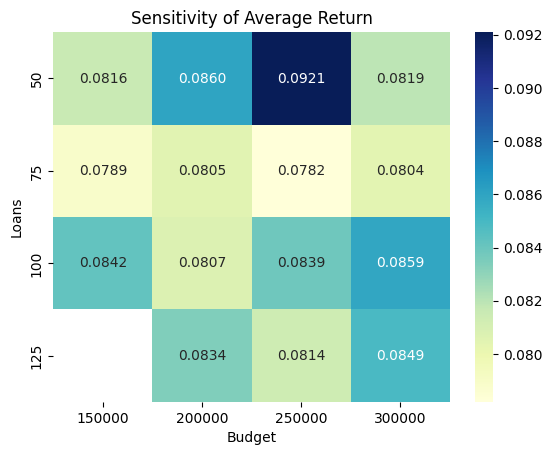

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_results.pivot(index="Loans", columns="Budget", values="Average Return")
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Sensitivity of Average Return")
plt.show()


Our sensitivity analysis shows that the highest returns occur with fewer loans and a moderate budget, highlighting the optimizer's preference for concentrated, high-quality investments. Varying the number of clusters (K) had minimal impact on performance, confirming the model’s robustness to risk segmentation.
















Sensitivity using different Ks


🔄 Running for K = 10

🔄 Running for K = 15

🔄 Running for K = 20

🔄 Running for K = 25

🔄 Running for K = 30


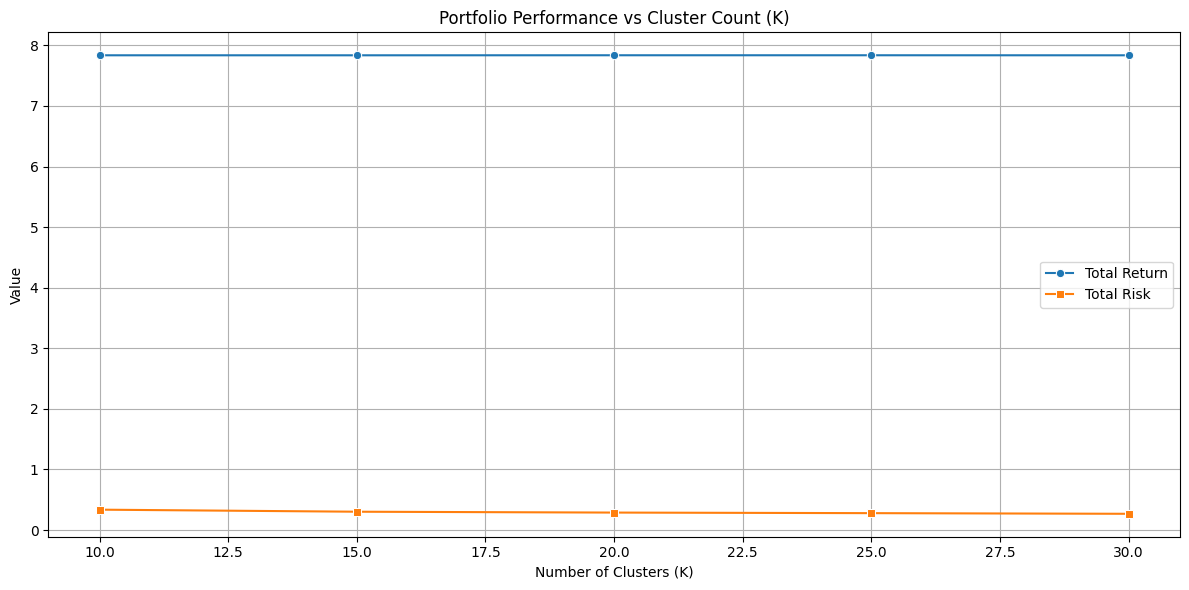

In [113]:
from gurobipy import GRB, Model
import matplotlib.pyplot as plt
import seaborn as sns

k_values = [10, 15, 20, 25, 30]
k_results = []

for K in k_values:
    print(f"\n Running for K = {K}")

    # Step 1: KMeans clustering on training data
    kmeans = KMeans(n_clusters=K, random_state=42)
    train_clusters = kmeans.fit_predict(X_train_scaled)
    train_df['cluster'] = train_clusters

    # Step 2: Compute risk per cluster
    cluster_risk_map = train_df.groupby('cluster')['predicted_return'].std().to_dict()

    # Step 3: Assign cluster + risk to test set
    test_clusters = kmeans.predict(X_test_scaled)
    test_df['cluster'] = test_clusters
    test_df['risk_score'] = test_df['cluster'].map(cluster_risk_map)

    # Step 4: Sample and prepare test data for optimization
    df = test_df.copy().dropna(subset=['predicted_return', 'risk_score', 'loan_amnt'])
    df = df.sample(n=1000, random_state=42)
    df = df.reset_index(drop=True)

    try:
        m = Model()
        m.setParam('OutputFlag', 0)

        x = m.addVars(len(df), vtype=GRB.BINARY, name='x')

        # Parameters
        BETA = 1.0
        NUM_LOANS = 100
        BUDGET = 375000

        # Objective: maximize risk-adjusted return
        m.setObjective(
            sum(x[i] * df.loc[i, "loan_amnt"] *
                (df.loc[i, "predicted_return"] - BETA * df.loc[i, "risk_score"])
                for i in range(len(df))),
            GRB.MAXIMIZE
        )

        # Constraints
        m.addConstr(sum(x[i] for i in range(len(df))) == NUM_LOANS)
        m.addConstr(sum(x[i] * df.loc[i, "loan_amnt"] for i in range(len(df))) <= BUDGET)

        # Grade diversification
        for grade in df['grade'].unique():
            m.addConstr(
                sum(x[i] for i in range(len(df)) if df.loc[i, "grade"] == grade) <= 0.3 * NUM_LOANS
            )

        m.optimize()

        if m.status == GRB.OPTIMAL:
            selected = [i for i in range(len(df)) if x[i].X > 0.5]
            total_return = df.loc[selected, "predicted_return"].sum()
            avg_return = df.loc[selected, "predicted_return"].mean()
            total_risk = df.loc[selected, "risk_score"].sum()
            avg_risk = df.loc[selected, "risk_score"].mean()

            k_results.append({
                'K': K,
                'Total Return': total_return,
                'Average Return': avg_return,
                'Total Risk': total_risk,
                'Average Risk': avg_risk,
                'Loans Selected': len(selected),
                'Feasible': True
            })
        else:
            k_results.append({'K': K, 'Feasible': False})

    except Exception as e:
        print(f" Gurobi error at K={K}: {e}")
        k_results.append({'K': K, 'Feasible': False})

# Create DataFrame
df_k_results = pd.DataFrame(k_results)

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_k_results[df_k_results['Feasible']], x='K', y='Total Return', marker='o', label='Total Return')
sns.lineplot(data=df_k_results[df_k_results['Feasible']], x='K', y='Total Risk', marker='s', label='Total Risk')
plt.title("Portfolio Performance vs Cluster Count (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Our portfolio optimization remained stable across different clustering granularities (K=10 to K=30), suggesting that the model’s return and risk estimates are robust to moderate changes in cluster definition. This reinforces confidence in the reliability of our cluster-based risk estimation.

## Explaining rules for selection

In [114]:
selected = [i for i in range(len(df)) if x[i].X > 0.5]
df_selected = df.loc[selected].copy()

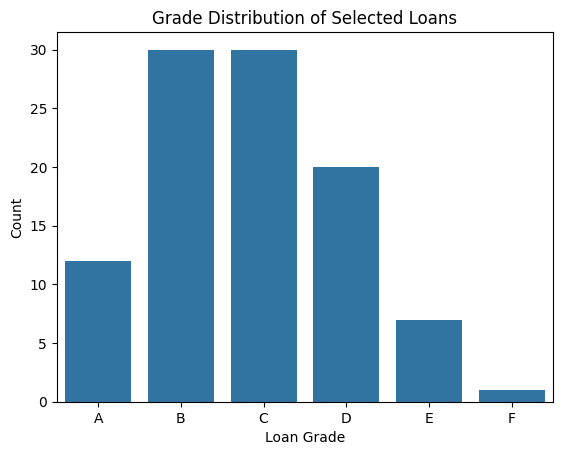

In [115]:
sns.countplot(data=df_selected, x='grade', order=sorted(df_selected['grade'].unique()))
plt.title("Grade Distribution of Selected Loans")
plt.xlabel("Loan Grade")
plt.ylabel("Count")
plt.show()


The optimized portfolio mainly selects loans from Grades B and C, indicating a preference for loans that offer a strong balance between moderate risk and solid return. Fewer loans are chosen from Grades A (lower return) and E/F (higher risk), showing that the optimizer avoids extremes.

Underlying rule: Favor mid-grade loans (B/C) where the expected return is high enough to justify the risk, but not so risky as to significantly increase portfolio volatility.

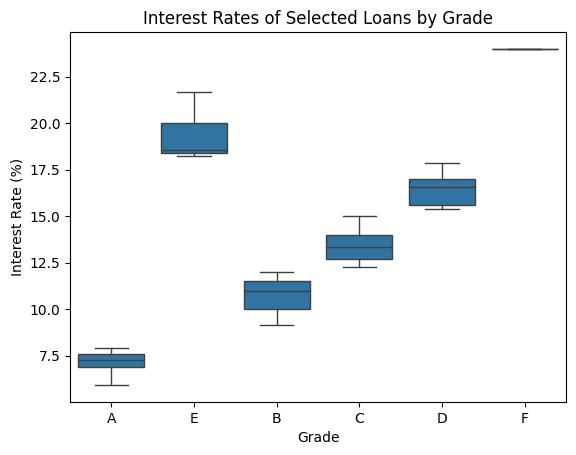

In [116]:
sns.boxplot(data=df_selected, x='grade', y='int_rate')
plt.title("Interest Rates of Selected Loans by Grade")
plt.ylabel("Interest Rate (%)")
plt.xlabel("Grade")
plt.show()


This chart shows that selected loans from mid-grades (B–D) offer moderate to high interest rates, while extreme grades (A and F) lie at the low and high ends respectively.

Underlying rule: The optimizer targets grades that provide attractive interest rates without taking on excessive risk—avoiding the lowest-return (A) and highest-risk (F) loans.

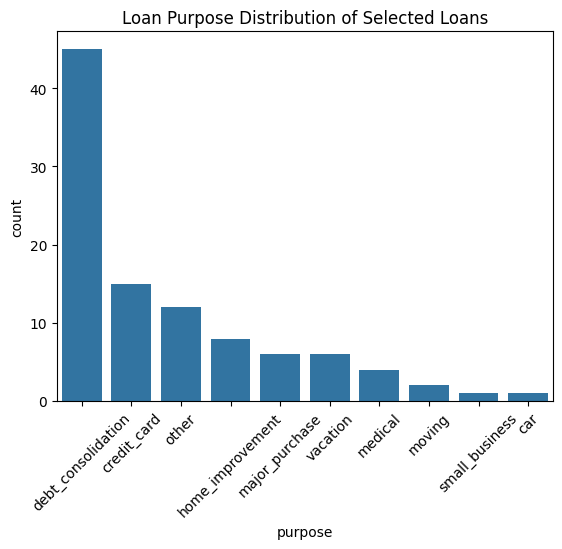

In [117]:
sns.countplot(data=df_selected, x='purpose', order=df_selected['purpose'].value_counts().index)
plt.title("Loan Purpose Distribution of Selected Loans")
plt.xticks(rotation=45)
plt.show()


The optimizer heavily favors loans for debt consolidation and credit card repayment, likely because these are associated with clearer financial need and more predictable repayment patterns.

Underlying rule: Prioritize common, lower-risk purposes like debt consolidation while avoiding riskier or less structured purposes such as small business or car loans.

In [118]:
df_selected[['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'risk_score']].describe()


,loan_amnt,int_rate,annual_inc,dti,risk_score
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3749.250000,12.956100,61837.428000,15.750100,0.002676
std,1553.212112,3.610205,32518.415706,8.280448,0.000382
min,1000.000000,5.930000,10000.000000,2.400000,0.002383
25%,2643.750000,10.902500,37006.000000,9.547500,0.002444
50%,4000.000000,12.690000,51000.000000,15.305000,0.002514
75%,4806.250000,15.460000,83000.000000,20.697500,0.002792
max,12600.000000,23.990000,150000.000000,37.640000,0.003862


Future work can explore alternative risk estimation techniques such as PCA-based clustering or volatility modeling using historical performance. Additionally, incorporating borrower-level behavioral data or macroeconomic indicators could improve prediction accuracy. Extending the framework to support dynamic portfolio rebalancing over time would further align it with real-world investment scenarios.







